# Causal Inference in Decision Intelligence – Part 6: Testing and Experimentation

Link to the article:  [Testing and Experimentation](https://www.python.org)

## Import libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from scipy.stats import beta

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set up the style of graphs
plt.style.use('fivethirtyeight')

## Generate synthetic data

In [2]:
np.random.seed(4)

# Create two promo campaigns
Promo1 = np.concatenate((np.zeros(1000), np.ones(1000)))
Promo2 = np.concatenate((np.zeros(500), np.ones(500), np.zeros(500), np.ones(500)))

# Create variants of Sales variable
# Without interaction between the promos
Sales_ab1 = 100 + 3 * Promo1 + np.random.randn(2000)
Sales_ab2 = 100 + 2 * Promo2 + np.random.randn(2000)

# With interaction between the promos
Sales_doe1 = 100 + 3 * Promo1 + 2 * Promo2 + 5 * Promo1 * Promo2 + np.random.randn(2000)
Sales_doe2 = 100 + 0 * Promo1 + 0 * Promo2 + 12 * Promo1 * Promo2 + np.random.randn(2000)

# Create a dataframe
df = pd.DataFrame({'Promo1': Promo1, 'Promo2': Promo2, 'Sales_ab1': Sales_ab1, 
                   'Sales_ab2': Sales_ab2, 'Sales_doe1': Sales_doe1, 'Sales_doe2': Sales_doe2})

## Analyze A/B tests results

### A/B test 1

In [3]:
# Use statistics
Uplift_ab1 = df[df.Promo1==1].Sales_ab1.mean() - df[df.Promo1==0].Sales_ab1.mean()
print(f'Uplift of Promo 1: {round(Uplift_ab1, 2)}')

Uplift of Promo 1: 2.95


In [4]:
# Use linear regression 
smf.ols('Sales_ab1 ~ Promo1', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,100.0515,0.031,3260.254,0.000,99.991,100.112
Promo1,2.9503,0.043,67.979,0.000,2.865,3.035


### A/B test 2

In [5]:
# Use statistics
Uplift_ab2 = df[df.Promo2==1].Sales_ab2.mean() - df[df.Promo2==0].Sales_ab2.mean()
print(f'Uplift of Promo 2: {round(Uplift_ab2, 2)}')

Uplift of Promo 2: 1.95


In [6]:
# Use linear regression 
smf.ols('Sales_ab2 ~ Promo2', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,100.0121,0.031,3198.186,0.000,99.951,100.073
Promo2,1.9480,0.044,44.048,0.000,1.861,2.035


## Analyze Design of Experiments results

### DoE with positive uplifts and an interaction effect

In [7]:
# Use statistics
round(pd.pivot_table(df, values="Sales_doe1", index="Promo1", columns="Promo2", aggfunc="mean"), 2)

Promo2,0.0,1.0
Promo1,,
0.0,100.00,102.01
1.0,103.02,109.99


In [8]:
# Use linear regression
smf.ols('Sales_doe1 ~ Promo1 * Promo2', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,99.9990,0.045,2243.560,0.000,99.912,100.086
Promo1,3.0255,0.063,47.998,0.000,2.902,3.149
Promo2,2.0119,0.063,31.918,0.000,1.888,2.136
Promo1:Promo2,4.9533,0.089,55.566,0.000,4.778,5.128


### DoE with zero uplifts and an interaction effect

In [9]:
# Use statistics
round(pd.pivot_table(df, values="Sales_doe2", index="Promo1", columns="Promo2", aggfunc="mean"), 2)

Promo2,0.0,1.0
Promo1,,
0.0,100.03,100.00
1.0,100.00,111.98


In [10]:
# Use linear regression
smf.ols('Sales_doe2 ~ Promo1 * Promo2', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,100.0320,0.045,2223.942,0.000,99.944,100.120
Promo1,-0.0348,0.064,-0.547,0.584,-0.160,0.090
Promo2,-0.0333,0.064,-0.524,0.601,-0.158,0.091
Promo1:Promo2,12.0191,0.090,133.606,0.000,11.843,12.196


The individual coefficients for Promo 1 and Promo 2 are not statistically different from zero and the interaction coefficient is 12  as expected. 

# Run Thomson Sampling test

In [11]:
# Set the number of trials and probabilitiess 
n_trials = 2000             # Number of customers targeted
probabilities = [0.2, 0.5]  # Probabilites of buying for variants 1 and 2

In [12]:
# Create a class for updating Beta distributions after each round

np.random.seed(10)

class Bandit:
  def __init__(self, p):
    self.p = p
    self.a = 1
    self.b = 1
    self.N = 0 # for information only

  def pull(self):
    return np.random.random() < self.p

  def sample(self):
    return np.random.beta(self.a, self.b)

  def update(self, x):
    self.a += x
    self.b += 1-x
    self.N += 1

In [17]:
# Create a function for plotting the results

def plot(bandits, trial):
    """
    Plots a diagram showing the results of an experiment.

    Parameters:
    bandits: Variants of the test.
    trial: The trial number to be displayed.
    """
    x = np.linspace(0, 1, 200)
    for b in bandits:
        y = beta.pdf(x, b.a, b.b)
        plt.plot(x, y, label=f"real p: {b.p:.4f}, win rate = {b.a - 1}/{b.N}")
    plt.title(f"Bandit distributions after {trial} trials")
    plt.legend()
    plt.show()

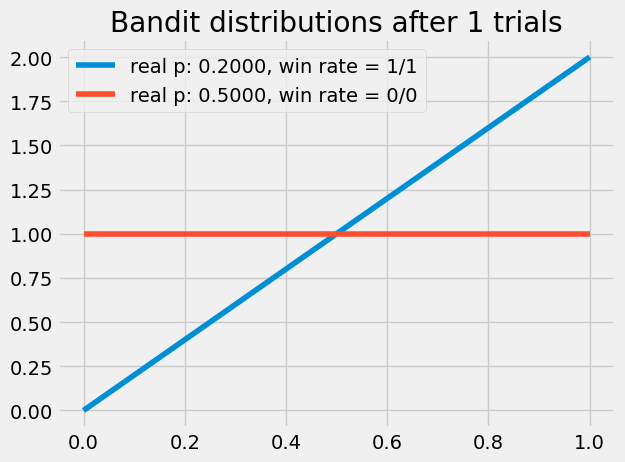

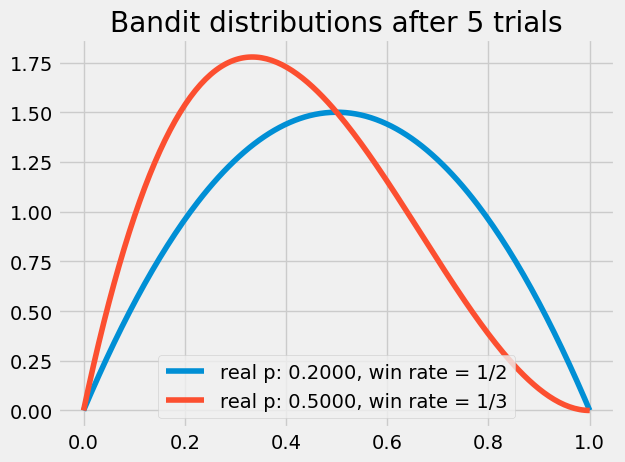

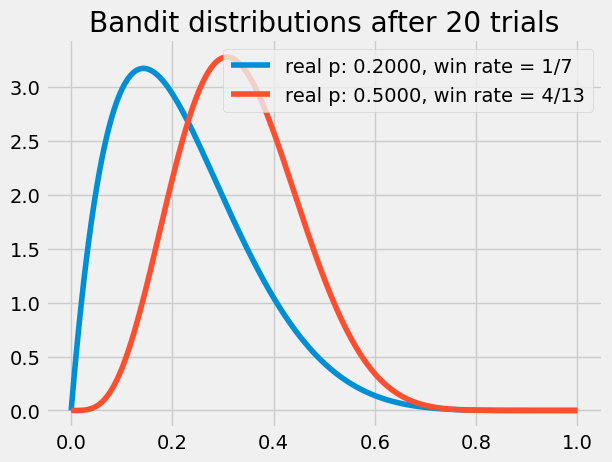

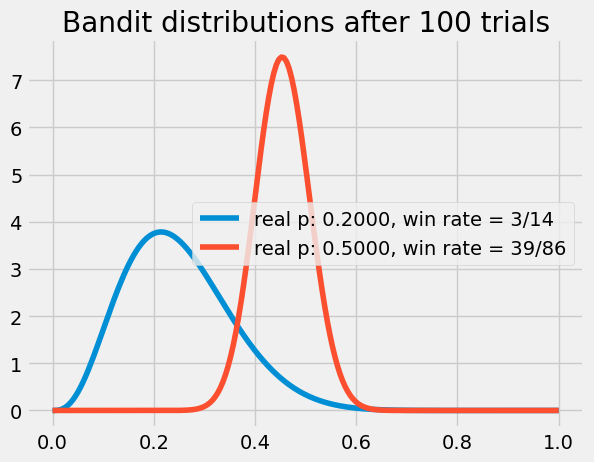

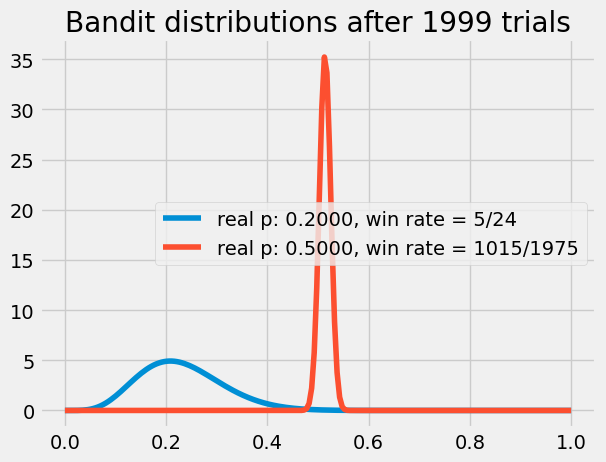

Total reward earned: 1020.0
Overall win rate: 0.51
Num times selected each variant: [24, 1976]


In [20]:
# Create a function for running the experiment
def experiment():
    """
     Creates an instance of the Bandit class for each variant, runs an experiment, 
     and visualizes the results for each sample point in `sample_points`.
     
    """
    np.random.seed(10)
    bandits = [Bandit(p) for p in probabilities]

    sample_points = [1,5,20,100,1999]
    rewards = np.zeros(n_trials)
    for i in range(n_trials):
        # Thompson sampling
        j = np.argmax([b.sample() for b in bandits])

        # plot the posteriors
        if i in sample_points:
          plot(bandits, i)

        # pull the arm for the bandit with the largest sample
        x = bandits[j].pull()

        # update rewards
        rewards[i] = x

        # update the distribution for the bandit whose arm we just pulled
        bandits[j].update(x)

    # print total reward
    print("Total reward earned:", rewards.sum())
    print("Overall win rate:", rewards.sum() / n_trials)
    print("Num times selected each variant:", [b.N for b in bandits])


if __name__ == "__main__":
  experiment()